<a href="https://colab.research.google.com/github/chhyyi/aiffel/blob/main/kaggle_notebook_copy/Sentiment_Analysis_on_Movie_Review.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Analysis on Movie Review
This notebook follows a colab notebook, ["End-to-End NLP (EDA & ML) with Sentiment Analysis" by Sammy Ongaya](https://www.kaggle.com/code/sammir/end-to-end-nlp-eda-ml-with-sentiment-analysis/notebook). This notebook is part of NLP study I attended as a part of Modulab's AIFFEL course.

# 파일 준비
캐글에서 다운받아서 올렸습니다.

In [1]:
path='/content/drive/MyDrive/colabdata/kaggle_study/rottentomato/'
file_submission_sample='sampleSubmission.csv'
file_test_data='test.tsv.zip'
file_train_data='train.tsv.zip'

#test file paths
f=open(path+file_submission_sample, 'r')
print(len(f.readline()))

19


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk import ngrams

## nltk와 nltk에서 import된 것들 알아보기
1. nltk는 자연어(natural language)를 다루기 위한 패키지(toolkit)입니다. 관련한 많은 데이터셋과 라이브러리를 쉽게 사용하기 위한 인터페이스를 제공합니다.
2. tokenize의 word_tokenize()는 텍스트를 받아서 단어와 구두점의 리스트를 반환(토큰화)합니다. 언어나 줄바꿈에 대한 처리를 입력받습니다.
3. stopwords는 이른바 '불용어'의 사전입니다. 데이터타입은 LazyCorpusLoader인데 proxy obejct라고 합니다. 아마 바로 데이터를 불러오면 큰 corpus를 다룰 일이 많은 텍스트 처리에서 낭비가 될 수 있어 쓰는 거 같습니다. 더 자세히 알아보기 위해
```python
nltk.download('stopwords')
stopwords.ensure_loaded()
print(type(stopwords), stopwords.raw())
```
이것을 실행했지만 이번에는 stopwords의 타입이  
nltk.corpus.reader.wordlist.WordListCorpusReader
으로 바뀌었고, raw() method를 통해 각종 문자로 쓰여있는 문자열을 볼 수는 있었습니다.

4. probability의 FreqDist: collections.Counter를 상속합니다. frequency distribution이라고 하는데 frequency는 다음과 같이 설명됩니다.
> the count of that sample divided by the total number of sample outcomes  

5. ngrams는 주어진 sequence 혹은 iterator의 ngrams 출력합니다. ngrams는 연속되게 특정 길이로 자를 수 있는 경우를 모두 모은 것입니다. 예를 들면 [2,3,4,5]의 3 grams는 [2,3,4]와 [3,4,5]입니다.

In [3]:
import string

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
# https://scikit-learn.org/stable/modules/feature_extraction.html#
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

import warnings, os

### Imported package 알아보기 (계속)
1. countvectorizer는 count 결과를 csr matrix (scipy에서 원래 쓰는거)로 내놓는다고 한다.  
2. TfidfVectorizer는 에서 앞부분은 term frequency - inverse documnet frequency 라고 한다. 큰 corpus에서 a, is, the 처럼 어느 문서든 상관없이 많이 쓰이는 것들을 좀 더 덜 쓰이지만 특정 문서에서는 많이 쓰이는 것과 구별하려는 것 같다.

In [4]:
plt.figure(figsize=(16,7))
plt.style.use('ggplot')
warnings.filterwarnings('ignore')

<Figure size 1152x504 with 0 Axes>

# Load Data

In [5]:
for dirname, _, filenames in os.walk('/content/drive/MyDrive/colabdata/kaggle_study/rottentomato'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/content/drive/MyDrive/colabdata/kaggle_study/rottentomato/train.tsv.zip
/content/drive/MyDrive/colabdata/kaggle_study/rottentomato/test.tsv.zip
/content/drive/MyDrive/colabdata/kaggle_study/rottentomato/sampleSubmission.csv


In [6]:
train=pd.read_csv('/content/drive/MyDrive/colabdata/kaggle_study/rottentomato/train.tsv.zip', sep='\t')
test=pd.read_csv('/content/drive/MyDrive/colabdata/kaggle_study/rottentomato/test.tsv.zip', sep='\t')

In [7]:
train.shape, test.shape

((156060, 4), (66292, 3))

In [8]:
print(_)

[]


## 새로 알게된 method/기능들
- os.walk: 경로를 입력하면 dirpath, 하위 directory 이름들, 하위 filenames를 출력시킨다. 우리의 데이터파일은 두 개의 tsv.zip 파일과 하나의 csv파일이 subdirectory 없이 있으니까 이게 맞다. 참고로 subdirectory에는 './'과 '../'도 있는데 제외한다고 한다.
- tsv.zip파일은 readline으로 해보니까 안열리는 것을 생각했을 때 압축이 된 거는 맞는 거 같다. 그런데 이게 그냥 read_csv로 열린다?

In [9]:
train.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [10]:
test.head()

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine


In [11]:
print(train['Phrase'][5:15])

5     of escapades demonstrating the adage that what...
6                                                    of
7     escapades demonstrating the adage that what is...
8                                             escapades
9     demonstrating the adage that what is good for ...
10                              demonstrating the adage
11                                        demonstrating
12                                            the adage
13                                                  the
14                                                adage
Name: Phrase, dtype: object


# 데이터셋: 로튼토마토 리뷰?
웬일인지 문장이 phrase 단위로 토막나서 나뉘어있는데 기준을 잘 모르겠다. 왜 of, the 같은 것을 굳이 분리해놓았을까? 나머지는 감정이 담길 수 있는 단위라는 느낌이 오는데
0부터 4까지 감정이 채점돼있다. 가장 부정적인 것이 0, 중립적인 태도가 2이다.

# 텍스트 전처리

In [12]:
train['Sentiment_class']=train['Sentiment'].map({0:'negative', 1:'somewhat negative', 2:'neutral', 3:'somewhat positive', 4:'positive'})
train.head()

,PhraseId,SentenceId,Phrase,Sentiment,Sentiment_class
0,1,1,A series of escapades demonstrating the adage ...,1,somewhat negative
1,2,1,A series of escapades demonstrating the adage ...,2,neutral
2,3,1,A series,2,neutral
3,4,1,A,2,neutral
4,5,1,series,2,neutral


sentiment_class라는 column을 추가하는데 왜 했는지 모르겠다.

## 구두점 제거

In [13]:
def remove_punctuation(text):
    return "".join([t for t in text if t not in string.punctuation])

train['Phrase']=train['Phrase'].apply(remove_punctuation)
print(train.head())

   PhraseId  SentenceId                                             Phrase  \
0         1           1  A series of escapades demonstrating the adage ...   
1         2           1  A series of escapades demonstrating the adage ...   
2         3           1                                           A series   
3         4           1                                                  A   
4         5           1                                             series   

   Sentiment    Sentiment_class  
0          1  somewhat negative  
1          2            neutral  
2          2            neutral  
3          2            neutral  
4          2            neutral  


여기서 lamda function왜씀? 바로 remove_punctuation 하면 되는데. 그냥 lambda function을 쓰고 싶었던 것 같다. 저걸 할거면 함수를 define할 필요가 없고 그냥 lambda를 쓰지. 아무튼 "".join은 캐글 전처리에서 많이 보던 것이고, string.punctuation 은 그냥 구두점 모음이다.  

# 셋 이상인 단어만 남기기
원래 글자수가 둘 미만인 단어만 남긴다고 돼 있었고, 실제로는 char>=3인 단어들만 남겨서 이름을 수정하였다.

In [14]:
def more_than_three_chars(text):
    return " ".join([t for t in text.split() if len(t)>=3])

train['Phrase']=train['Phrase'].apply(more_than_three_chars)
train.head()

,PhraseId,SentenceId,Phrase,Sentiment,Sentiment_class
0,1,1,series escapades demonstrating the adage that ...,1,somewhat negative
1,2,1,series escapades demonstrating the adage that ...,2,neutral
2,3,1,series,2,neutral
3,4,1,,2,neutral
4,5,1,series,2,neutral


## remove stopwords
download를 하지 않으면 문제가 된다. 
stopwords는 import된 패키지인데 이걸 나중에 변수 이름으로 써서 namespace에서 지워진다. 의도한 것인지....

In [15]:
from nltk import download
download('stopwords')
stop_words=stopwords.words('english')
train['Phrase']=train['Phrase'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))
train.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,PhraseId,SentenceId,Phrase,Sentiment,Sentiment_class
0,1,1,series escapades demonstrating adage good goos...,1,somewhat negative
1,2,1,series escapades demonstrating adage good goose,2,neutral
2,3,1,series,2,neutral
3,4,1,,2,neutral
4,5,1,series,2,neutral


이 줄을 추가해야 돌아갑니다. 노트북이 쓰였을때는 원래 그냥 됐을까요?
```python
from nltk import download
download('stopwords')
```

## Check sentiment category
groupby를 어떻게 써야 특정 column의 unique한 value들을 셀 수 있는지 헤맬 때가 많았는데 이분은 잘 쓰시네요.

In [16]:
train.groupby('Sentiment')['Sentiment'].count()

Sentiment
0     7072
1    27273
2    79582
3    32927
4     9206
Name: Sentiment, dtype: int64

## Visualize the target variable

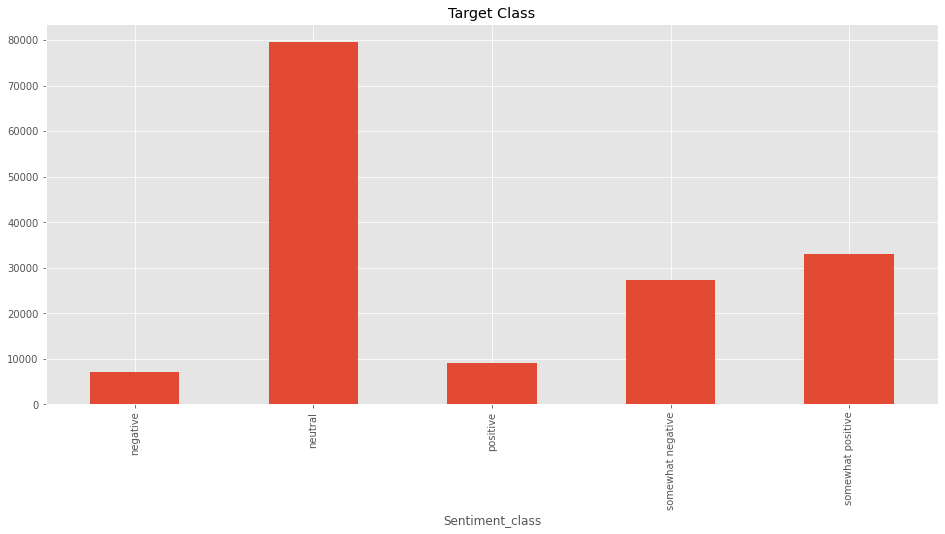

In [17]:
train.groupby('Sentiment_class')['Sentiment_class'].count().plot(kind='bar', title='Target Class', figsize=(16,7), grid=True)

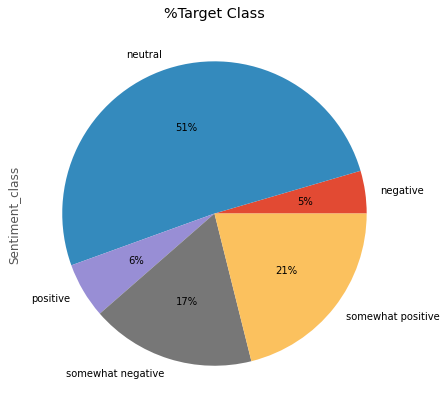

In [18]:
# get percentage of each class
((train.groupby('Sentiment_class')['Sentiment_class'].count()/train.shape[0])*100).plot(kind='pie',figsize=(7,7),title='%Target Class', autopct='%1.0f%%')

In [19]:
#adding phrase length
train['PhraseLength']=train['Phrase'].apply(len)

train.sort_values(by='PhraseLength', ascending=False).head()

,PhraseId,SentenceId,Phrase,Sentiment,Sentiment_class,PhraseLength
54876,54877,2734,Filmmakers Dana JanklowiczMann Amir Mann area ...,3,somewhat positive,215
26148,26149,1199,The movie biggest shocks come seeing former ny...,1,somewhat negative,211
62500,62501,3162,While transgressive trappings LRB especially f...,1,somewhat negative,209
62992,62993,3189,addition sporting one worst titles recent cine...,0,negative,208
105155,105156,5555,spiced humor LRB speak fluent flatula advises ...,3,somewhat positive,202


이 사람은 apply는 무조건 lambda랑 같이 쓰는 것 같습니다.

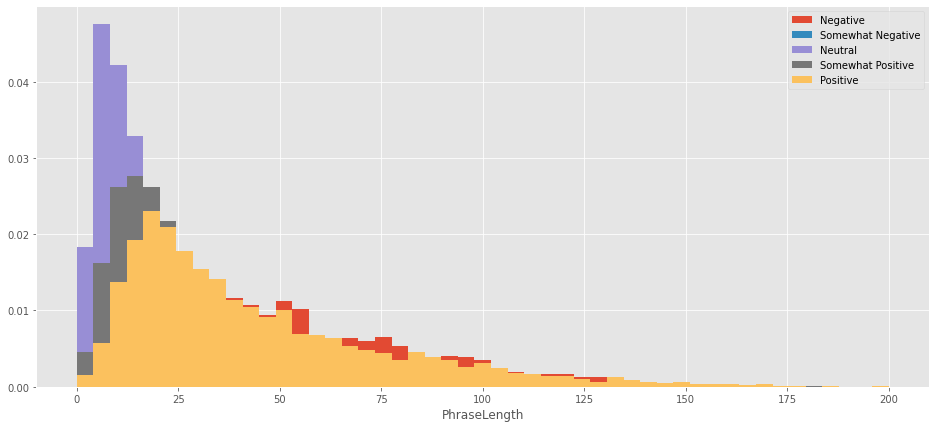

In [20]:
# Distribution of phrase length on each class
plt.figure(figsize=(16,7))
bins=np.linspace(0,200,50)
plt.hist(train[train['Sentiment_class']=='negative']['PhraseLength'],bins=bins,density=True, Label='Negative')
plt.hist(train[train['Sentiment_class']=='somewhat negative']['PhraseLength'],bins=bins,density=True, Label='Somewhat Negative')
plt.hist(train[train['Sentiment_class']=='neutral']['PhraseLength'],bins=bins,density=True, Label='Neutral')
plt.hist(train[train['Sentiment_class']=='somewhat positive']['PhraseLength'],bins=bins,density=True, Label='Somewhat Positive')
plt.hist(train[train['Sentiment_class']=='positive']['PhraseLength'],bins=bins,density=True, Label='Positive')
plt.xlabel('PhraseLength')
plt.legend()
plt.show()

In [21]:
#install wordcloud library
!pip3 install wordcloud

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [22]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

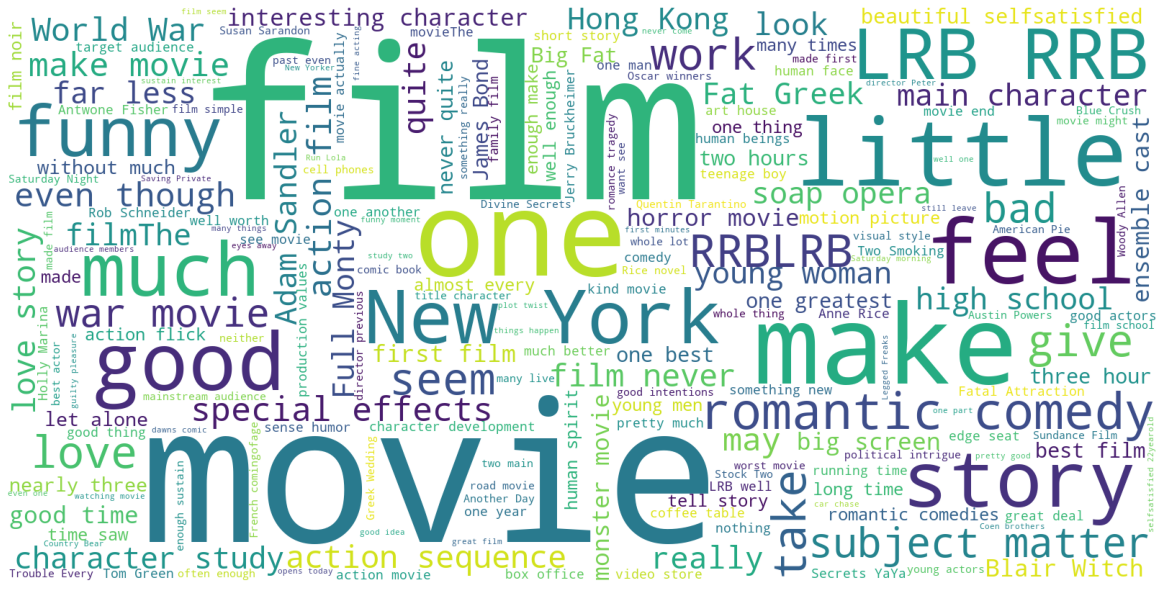

In [23]:
word_cloud_common_words=[]
for index, row in train.iterrows():
    word_cloud_common_words.append(row['Phrase'])

word_cloud_common_words

wordcloud=WordCloud(width=1600, height=800,
                    background_color='white',
                    stopwords=stopwords,
                    min_font_size=5).generate(''.join(word_cloud_common_words))

#flot the wordclouds image
plt.figure(figsize=(16,8), facecolor=None)
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)

plt.show()

In [24]:
# Word Frequency
download('punkt')
text_list=[]
for index, row in train.iterrows():
    text_list.append(row['Phrase'])
text_list

total_words=''.join(text_list)
total_words=word_tokenize(total_words)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [25]:
freq_words=FreqDist(total_words)
word_frequency=FreqDist(freq_words)

In [26]:
#10 common words
print(word_frequency.most_common(10))

[('film', 3674), ('movie', 3217), ('like', 2029), ('one', 1896), ('RRB', 1386), ('LRB', 1382), ('The', 1314), ('story', 1312), ('good', 1183), ('much', 1158)]


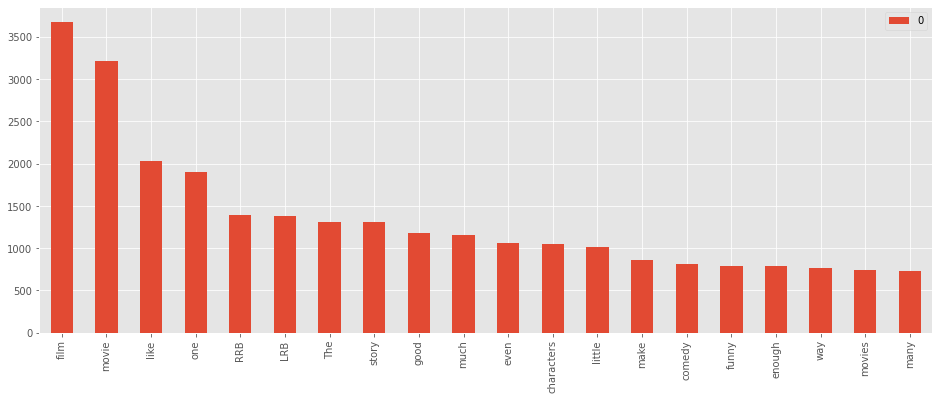

In [27]:
#visualize
pd.DataFrame(word_frequency, index=[0]).T.sort_values(by=[0], ascending=False).head(20).plot(kind='bar', figsize=(16,6),grid=True)

In [34]:
#common words used for negative sentiment
neg_text_list=[]
for index, row in train[train['Sentiment']==0].iterrows():
    neg_text_list.append(row['Phrase'])
neg_text_list

neg_total_words=' '.join(neg_text_list)
neg_total_words=word_tokenize(neg_total_words)

neg_freq_words=FreqDist(neg_total_words)
neg_word_frequency=FreqDist(neg_freq_words)

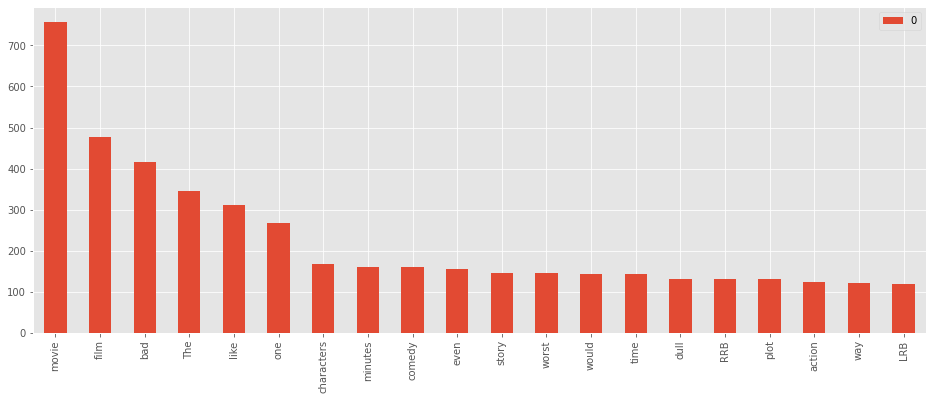

In [35]:
#visualize
pd.DataFrame(neg_word_frequency, index=[0]).T.sort_values(by=[0], ascending=False).head(20).plot(kind='bar', figsize=(16,6), grid=True)

In [38]:
# Common words used for positive sentiment
pos_text_list=[]
for index, row in train[train['Sentiment']==4].iterrows():
    pos_text_list.append(row['Phrase'])

pos_total_words=' '.join(pos_text_list)
pos_total_words=word_tokenize(pos_total_words)

pos_freq_words=FreqDist(pos_total_words)
pos_word_frequency=FreqDist(pos_freq_words)

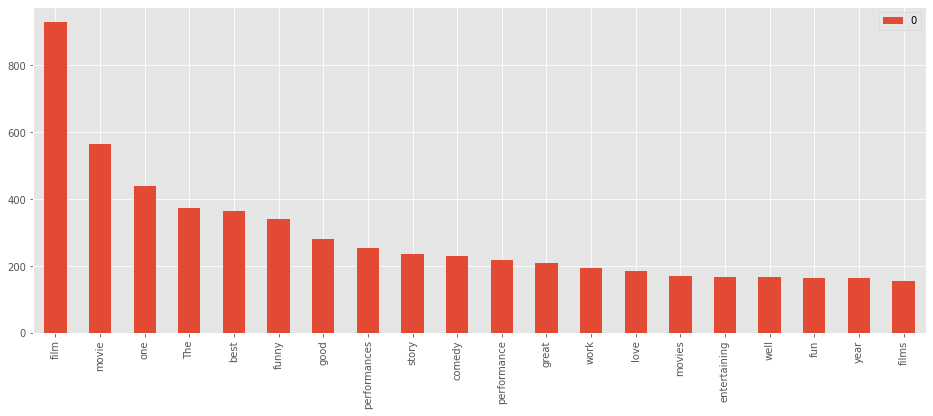

In [39]:
# visualize
pd.DataFrame(pos_word_frequency, index=[0]).T.sort_values(by=[0], ascending=False).head(20).plot(kind='bar', figsize=(16,6), grid=True)

In [40]:
# common bigram words used for positive sentiment
text="Tom and Jerry love mickey. But mickey dont love Tom and Jerry. What a love mickey is getting from these two friends"
bigram_frequency = FreqDist(ngrams(word_tokenize(text),3))
bigram_frequency.most_common()[0:5]

[(('Tom', 'and', 'Jerry'), 2),
 (('and', 'Jerry', 'love'), 1),
 (('Jerry', 'love', 'mickey'), 1),
 (('love', 'mickey', '.'), 1),
 (('mickey', '.', 'But'), 1)]

In [41]:
text_list=[]
for index, row in train.iterrows():
    text_list.append(row['Phrase'])

total_words=' '.join(text_list)
total_words=word_tokenize(total_words)

freq_words=FreqDist(total_words)
word_frequency=FreqDist(ngrams(freq_words, 2))
word_frequency.most_common()[0:5]

[(('film', 'movie'), 1),
 (('movie', 'The'), 1),
 (('The', 'one'), 1),
 (('one', 'like'), 1),
 (('like', 'story'), 1)]

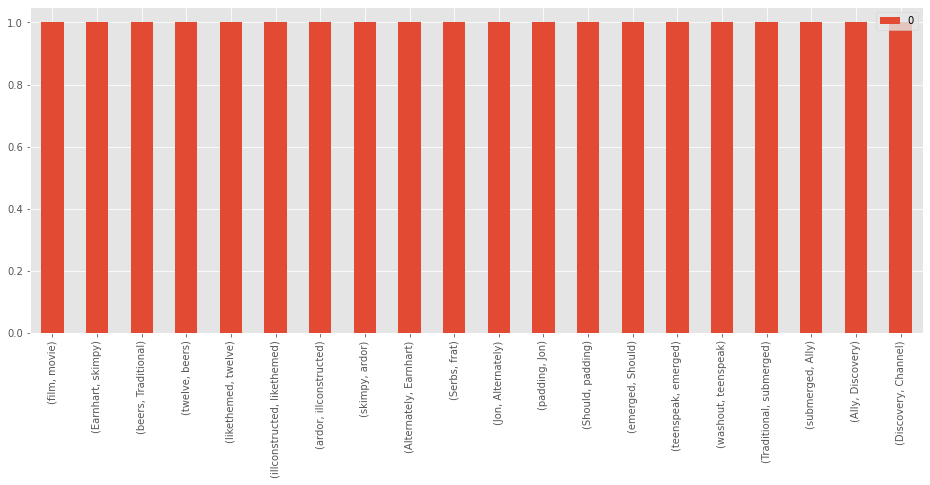

In [44]:
# visulaize
pd.DataFrame(word_frequency, index=[0]).T.sort_values(by=[0], ascending=False).head(20).plot(kind='bar', figsize=(16,6), grid=True)

# part 2 ML modeling
트레이닝 데이터를 준비하고, Bag of Words를 CountVectorizer로 만듭니다.

In [46]:
train['tokenized_words']=train['Phrase'].apply(word_tokenize)
train.head()

,PhraseId,SentenceId,Phrase,Sentiment,Sentiment_class,PhraseLength,tokenized_words
0,1,1,series escapades demonstrating adage good goos...,1,somewhat negative,108,"[series, escapades, demonstrating, adage, good..."
1,2,1,series escapades demonstrating adage good goose,2,neutral,47,"[series, escapades, demonstrating, adage, good..."
2,3,1,series,2,neutral,6,[series]
3,4,1,,2,neutral,0,[]
4,5,1,series,2,neutral,6,[series]


In [50]:
#missed I think...
train=train.dropna()

In [51]:
count_vectorizer=CountVectorizer()
phrase_dtm=count_vectorizer.fit_transform(train['Phrase'])
#dtm : docuemnt - term measure matrix

In [52]:
phrase_dtm.shape

(156060, 16191)

In [54]:
X_train, X_val, y_train, y_val=train_test_split(phrase_dtm, train['Sentiment'], test_size=0.3, random_state=38)
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((109242, 16191), (109242,), (46818, 16191), (46818,))

In [55]:
model=LogisticRegression()

In [56]:
model.fit(X_train,y_train)

LogisticRegression()

In [57]:
accuracy_score(model.predict(X_val), y_val)*100

64.07578281857405

In [58]:
#free up memory for tf-idf
del X_train, X_val, y_train, y_val

In [59]:
tfidf=TfidfVectorizer()
tfidf_dtm=tfidf.fit_transform(train['Phrase'])

In [61]:
X_train, X_val, y_train, y_val = train_test_split(tfidf_dtm, train['Sentiment'], test_size=0.3, random_state=38)
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((109242, 16191), (109242,), (46818, 16191), (46818,))

In [62]:
tfidf_model=LogisticRegression()

In [63]:
tfidf_model.fit(X_train, y_train)

LogisticRegression()

In [64]:
accuracy_score(tfidf_model.predict(X_val),y_val)*100

62.255969926096796

In [65]:
#Predict on test data
print(tfidf_model.predict(X_val)[0:10])

[3 2 2 2 3 2 2 3 2 3]


In [66]:
#new data prediction function
def predict_new_text(text):
    tfidf_text=tfidf.transform([text])
    return tfidf_model.predict(tfidf_text)

In [67]:
predict_new_text("The movie is bad and sucks!")

array([0])

In [68]:
test['Phrase']=test['Phrase'].apply(remove_punctuation)
test['Phrase']=test['Phrase'].apply(more_than_three_chars)
test['Phrase']=test['Phrase'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
test=test.dropna()
test_dtm=tfidf.transform(test['Phrase'])

In [69]:
#predict with test data
test['Sentiment']=tfidf_model.predict(test_dtm)
test.set_index=test['PhraseId']
test.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,156061,8545,intermittently pleasing mostly routine effort,3
1,156062,8545,intermittently pleasing mostly routine effort,3
2,156063,8545,,2
3,156064,8545,intermittently pleasing mostly routine effort,3
4,156065,8545,intermittently pleasing mostly routine,2
